In [129]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import tensorflow as tf
import keras
from keras.layers import Convolution1D, MaxPool1D, Dense, Flatten, Dropout
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## Data Preparation

In [100]:
train_df = pd.read_csv("/Users/amirzadc/Library/CloudStorage/OneDrive-WBA/Documents/Project_WH/ML_Projects/"
                       "ECG Heartbeat Categorization Dataset/mitbih_train.csv", header=None)
test_df = pd.read_csv("/Users/amirzadc/Library/CloudStorage/OneDrive-WBA/Documents/Project_WH/ML_Projects/"
                      "ECG Heartbeat Categorization Dataset/mitbih_test.csv", header=None)

In [102]:
# Data Preparation
train_df[187] = train_df[187].astype(int)

label_0_df = train_df[train_df[187] == 0]
label_1_df = train_df[train_df[187] == 1]
label_2_df = train_df[train_df[187] == 2]
label_3_df = train_df[train_df[187] == 3]
label_4_df = train_df[train_df[187] == 4]

label_0_df = label_0_df.sample(n=17500, random_state=42)
label_1_df = resample(label_1_df, replace=True, n_samples=17500, random_state=42)
label_2_df = resample(label_2_df, replace=True, n_samples=17500, random_state=42)
label_3_df = resample(label_3_df, replace=True, n_samples=17500, random_state=42)
label_4_df = resample(label_4_df, replace=True, n_samples=17500, random_state=42)

train_resample_df = pd.concat([label_0_df, label_1_df, label_2_df, label_3_df, label_4_df])

x = train_resample_df.iloc[:, :-1]
y = train_resample_df.iloc[:, -1].astype(int)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, shuffle=True)

x_test  = test_df.iloc[:, :-1]
y_test  = test_df.iloc[:, -1].astype(int)

y_train = to_categorical(y_train)
y_val   = to_categorical(y_val)
y_test  = to_categorical(y_test)




print("Number of training sample: " + str(x_train.shape))
print("Number of validation sample: " + str(x_val.shape))
print("Number of testing sample: " + str(test_df.shape))

print("Preparation is done")

Number of training sample: (74375, 187)
Number of validation sample: (13125, 187)
Number of testing sample: (21892, 188)
Preparation is done


In [103]:
y_train.shape

(74375, 5)

## Model Development

In [104]:
sample_shape = (x_train.shape[1], 1)
inputs = keras.Input(shape=sample_shape, name="inputs")

In [105]:
sample_shape

(187, 1)

In [106]:
x = Convolution1D(64, 6, activation='relu', input_shape=sample_shape)(inputs)
x = BatchNormalization()(x)
x = MaxPool1D(pool_size=3, strides=2, padding='same')(x)
x = Convolution1D(64, 3, activation='relu', input_shape=sample_shape)(x)
x = BatchNormalization()(x)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Convolution1D(64, 3, activation='relu', input_shape=sample_shape)(x)
x = BatchNormalization()(x)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x_output = Dense(5, activation='softmax', name="x_outputs")(x)


In [107]:
model = keras.Model(inputs=inputs, outputs=x_output, name="ecg_model")
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=["accuracy"])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model/best_model_v3.h5', monitor='val_loss', save_best_only=True)]



In [198]:
model.summary()

Model: "ecg_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 187, 1)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 182, 64)           448       
                                                                 
 batch_normalization_3 (Batc  (None, 182, 64)          256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 91, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 89, 64)            12352     
                                                                 
 batch_normalization_4 (Batc  (None, 89, 64)           25

In [9]:
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 187, 1), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name=None), name='x_outputs/Softmax:0', description="created by layer 'x_outputs'")


In [108]:
print(x_train.shape)
print(y_train.shape)

(74375, 187)
(74375, 5)


In [109]:
print(x_test.shape)
print(y_test.shape)

(21892, 187)
(21892, 5)


In [110]:
history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=40,
                    callbacks=callbacks,
                    validation_data=(x_val, y_val)
                    )



Epoch 1/40


2022-11-16 14:07:24.564372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2325/2325 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.9208

2022-11-16 14:08:01.842927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2325/2325 [==============================] - 41s 17ms/step - loss: 0.2223 - accuracy: 0.9208 - val_loss: 0.1258 - val_accuracy: 0.9536
Epoch 2/40
2325/2325 [==============================] - 40s 17ms/step - loss: 0.0893 - accuracy: 0.9685 - val_loss: 0.1070 - val_accuracy: 0.9650
Epoch 3/40
2325/2325 [==============================] - 41s 17ms/step - loss: 0.0619 - accuracy: 0.9787 - val_loss: 0.0834 - val_accuracy: 0.9728
Epoch 4/40
2325/2325 [==============================] - 40s 17ms/step - loss: 0.0458 - accuracy: 0.9846 - val_loss: 0.0474 - val_accuracy: 0.9848
Epoch 5/40
2325/2325 [==============================] - 40s 17ms/step - loss: 0.0370 - accuracy: 0.9871 - val_loss: 0.0711 - val_accuracy: 0.9780
Epoch 6/40
2325/2325 [==============================] - 40s 17ms/step - loss: 0.0324 - accuracy: 0.9896 - val_loss: 0.0652 - val_accuracy: 0.9767
Epoch 7/40
2325/2325 [==============================] - 40s 17ms/step - loss: 0.0281 - accuracy: 0.9912 - val_loss: 0.0816 - val_accura

In [111]:
model.load_weights('best_model.h5')

In [197]:
test_scores = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: ", test_scores[0])
print("test_accuracy: ", test_scores[1])

685/685 - 5s - loss: 0.1616 - accuracy: 0.9745 - 5s/epoch - 8ms/step
test_loss:  0.16163387894630432
test_accuracy:  0.9745112657546997


## Accuracy and Loss per Epoch

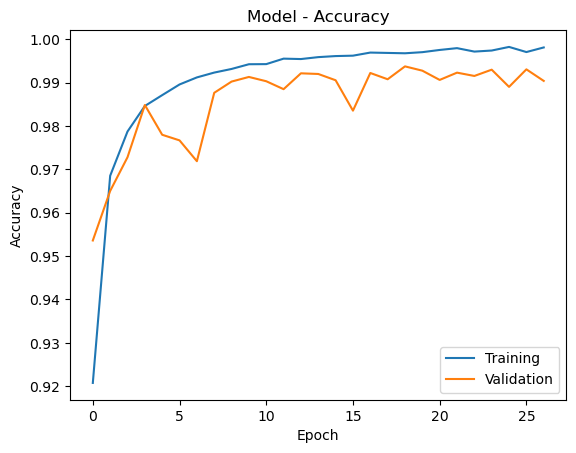

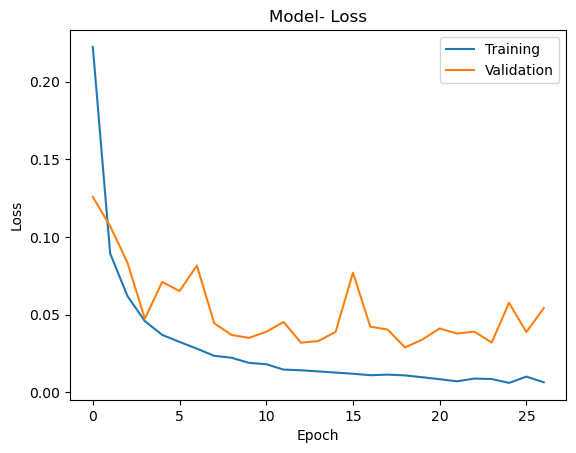

In [117]:

fig1, ax_acc = plt.subplots()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model - Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

fig2, ax_loss = plt.subplots()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model- Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


In [154]:
y_true=[]
for element in y_test:
    y_true.append(np.argmax(element))
prediction_proba=model.predict(x_test)
y_pred=np.argmax(prediction_proba,axis=1)

685/685 [==============================] - 2s 3ms/step


In [126]:
# listname = []
# for element in y_test:
#     listname.append(np.argmax(element))
# for cat in set(listname):
#     print([cat , listname.count(cat)])
# print("\n")
# for cat in set(prediction):
#     print([cat , list(prediction).count(cat)])    
    

In [155]:
cnf_matrix = confusion_matrix(y_true, y_pred)

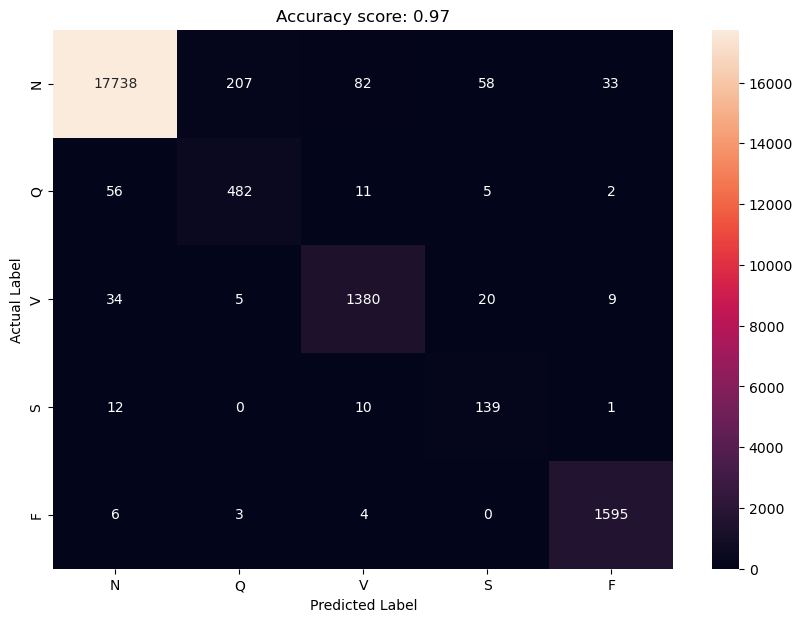

In [156]:
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in "NQVSF"],
                  columns = [i for i in "NQVSF"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.title('Accuracy score: 0.97')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [194]:
df_cm

,N,Q,V,S,F
N,17738,207,82,58,33
Q,56,482,11,5,2
V,34,5,1380,20,9
S,12,0,10,139,1
F,6,3,4,0,1595


In [157]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     18118
           1       0.69      0.87      0.77       556
           2       0.93      0.95      0.94      1448
           3       0.63      0.86      0.72       162
           4       0.97      0.99      0.98      1608

    accuracy                           0.97     21892
   macro avg       0.84      0.93      0.88     21892
weighted avg       0.98      0.97      0.98     21892



## Precision-Recall Curve

In [201]:
def assess_pr_curve(model, xtrain: np.ndarray, ytrain: np.ndarray, xval: np.ndarray, 
                    yval: np.ndarray, xtest: np.ndarray, ytest: np.ndarray, 
                    save_plot_path: Path, n_classes: int, class_labels: list):
    """
    Get Precision and Recall and P/R Curve plots for Validation and Test data
    """

    feature_extractor = Model(inputs = model.inputs, outputs = model.output) # extract dense output layer (will be softmax probabilities)

    y_train_score = feature_extractor.predict(xtrain, batch_size = 64) # softmax probabilities for training data
    y_train_binary = label_binarize(ytrain, classes = [0,1,2,3,4]) # one hot encode train data

    y_val_score = feature_extractor.predict(xval, batch_size = 64) # softmax probability for validation data
    y_val_binary = label_binarize(yval, classes = [0,1,2,3,4]) # one hot encode validation data

    y_test_score = feature_extractor.predict(xtest, batch_size = 64) # one hot encoded softmax predictions
    y_test_binary = label_binarize(ytest, classes = [0,1,2,3,4]) # one hot encode the test data true labels

    # Precision-Recall Curves for train/val/test
    train_precision = dict()
    train_recall = dict()
    train_avg_precision = dict()

    val_precision = dict()
    val_recall = dict()
    val_avg_precision = dict()

    test_precision = dict()
    test_recall = dict()
    test_avg_precision = dict()

    for i in range(n_classes):
        train_precision[i], train_recall[i], _ = precision_recall_curve(y_train_binary[:, i], y_train_score[:, i])
        train_avg_precision[i] = average_precision_score(y_train_binary[:, i], y_train_score[:, i])
        val_precision[i], val_recall[i], _ = precision_recall_curve(y_val_binary[:, i], y_val_score[:, i])
        val_avg_precision[i] = average_precision_score(y_val_binary[:, i], y_val_score[:, i])
        test_precision[i], test_recall[i], _ = precision_recall_curve(y_test_binary[:, i], y_test_score[:, i])
        test_avg_precision[i] = average_precision_score(y_test_binary[:, i], y_test_score[:, i])

    colors = cycle(['blue', 'red', 'green', 'brown', 'purple'])

    # plot each class curve on single graph for multi-class one vs all classification
    for i, color, lbl in zip(range(n_classes), colors, class_labels):
        plt.plot(train_recall[i], train_precision[i], color = color, lw = 2,
        label = 'P/R Curve of class {0} (avg = {1:0.3f})'.format(lbl, train_avg_precision[i]))
    plt.hlines(0, xmin = -0.02, xmax = 1.0, linestyle = 'dashed')
    plt.xlim([-0.02, 1.03])
    plt.ylim([-0.03, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Train P/R Curve for CIFAR-5 Multi-Class Data')
    plt.legend(loc = 'center left', prop = {'size': 6})
    fullpath = save_plot_path +'train_pr_curve.png'
    plt.savefig(fullpath)
    plt.close()


    # plot each class curve on single graph for multi-class one vs all classification
    for i, color, lbl in zip(range(n_classes), colors, class_labels):
        plt.plot(val_recall[i], val_precision[i], color = color, lw = 2,
        label = 'P/R Curve of class {0} (avg = {1:0.3f})'.format(lbl, val_avg_precision[i]))
    plt.hlines(0, xmin = -0.02, xmax = 1.0, linestyle = 'dashed')
    plt.xlim([-0.02, 1.03])
    plt.ylim([-0.03, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Validation P/R Curve CIFAR-5 Multi-Class Data')
    plt.legend(loc = 'center left', prop = {'size': 6})
    fullpath = save_plot_path +'val_pr_curve.png'
    plt.savefig(fullpath)
    plt.close()

    # plot each class curve on single graph for multi-class one vs all classification
    for i, color, lbl in zip(range(n_classes), colors, class_labels):
        plt.plot(test_recall[i], test_precision[i], color = color, lw = 2,
        label = 'P/R Curve of class {0} (avg = {1:0.3f})'.format(lbl, test_avg_precision[i]))
    plt.hlines(0, xmin = -0.02, xmax = 1.0, linestyle = 'dashed')
    plt.xlim([-0.02, 1.03])
    plt.ylim([-0.03, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Test P/R Curve for CIFAR-5 Multi-Class Data')
    plt.legend(loc = 'center left', prop = {'size': 6})
    plt.show()
    fullpath = save_plot_path +'test_pr_curve.png'
    plt.savefig(fullpath)
    plt.close()
  

  38/1163 [..............................] - ETA: 3s

2022-11-16 16:26:36.266416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


343/343 [==============================] - 1s 3ms/step


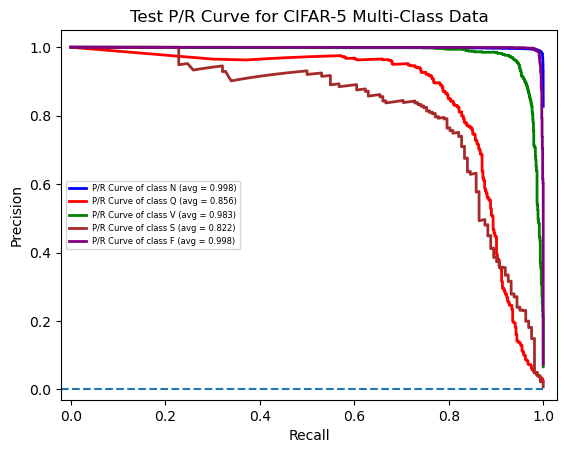

In [202]:
class_labels = ["N","Q", "V", "S", "F"]
assess_pr_curve(model, x_train, y_train, x_val, y_val, x_test, y_test, 
                    save_plot_path="./plot/", n_classes = 5, class_labels = class_labels )